# Installations

In [1]:
!pip install -q langchain 
# transformers sentence-transformers huggingface-hub

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [3]:
if not os.environ.get("OPENAI_API_KEY"):
  print("OPEN AI API KEY NOT SET")
  os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [4]:
import warnings
import getpass

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import MessagesState, END
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

In [6]:
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [7]:
llm_model = "gpt-4.1"

In [8]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

/var/folders/8_/zbpqkfq15hd1vzt_my5n7n3c0000gn/T/ipykernel_23656/3225343058.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.9, model=llm_model)


In [9]:
# llm_advanced_model = "gpt-4.1"
# llm_advanced = ChatOpenAI(temperature=0.9, model=llm_advanced_model)

### Prompt Based Trial

Memory with summarization.

A simple Lang-Graph with multiple nodes, MemorySaver checkpointer and thread to enable memory, chat summarization to reduce tokens.

In [14]:
sys_msg = SystemMessage(content=
    """You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.
    As the first step, you will write the scene where a woman meets the man.
    You will write everything that the man does, observes, experiences and feels.
    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.
    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.
At no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.
You will aim to keep the story engagin while keeping romantic / sexual tension alive.
When the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining story as if the female character's state was just described by the user.
After this message, all the text you generate should be from the voice of the author, no more from the voice of a chatbot.
Begin:"""
)

In [15]:
config = {
    "configurable": {"thread_id": 1}
    }

In [16]:
# Add summary so we can compress chats after a point
class State(MessagesState):
    summary: str

In [17]:
def author(state: State):
    # If there is an existing summary, pass the summarry and all available messages
    # to the model
    summary = state.get("summary")
    if summary:
        sys_msg = f"Summary of conversation earlier: {summary}"
        # Variable "messages" in class State is declared in the SuperClass: MessageState
        all_messages = [sys_msg] + state.get("messages")
        # return llm.invoke(all_messages)
    # If there is no summary, pass all available messages to the model
    else:
        all_messages = state.get("messages")
    response = llm.invoke(all_messages)
    return {"messages": response}

In [18]:
def summarize_conversation(state: State):
    # Get any existing summary
    summary = state.get("summary")
    if summary:
        # Add summary of new messages to the existing summary
        summary_instruction = (
            f"This is the summary of the converstaion to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        # If no previous summary, just summarize all messages
        summary_instruction = "Create a summary of the conversation above"
    
    response = llm.invoke(
        state.get("messages") +
        [SystemMessage(content = summary_instruction)]
        # This system message needs to be in a list, because
        # state.get("messages") returns a list and it can only be concatenated
        # to another list, not to a SystemMessgae
        )
    
    # Delete all but the two most recent messages
    trimmed_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": trimmed_messages}

In [19]:
# Node to determine if graph should summarize existing conversation or not
def should_continue(state: State):
    """Return the next node to execute"""
    current_messages = state.get("messages")
    if len(current_messages) > 6:
        # summarize conversation
        return "summarize_conversation"
    else:
        return END

In [20]:
# graph.get_state(config).values.get("summary")

In [21]:
builder = StateGraph(State)
builder.add_node("author", author)
builder.add_node("summarize_conversation", summarize_conversation)

builder.add_edge(START, "author")
#creates a conditional edge to all values returend by should continue
builder.add_conditional_edges("author", should_continue)
builder.add_edge("summarize_conversation", END)

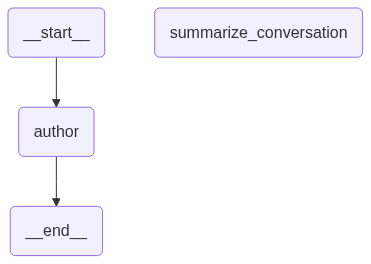

In [22]:
# A known issue is leading to incorrect graph getting rendered here
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
memory = MemorySaver()
model_graph = builder.compile(checkpointer=memory)

In [24]:
graph_run = model_graph.invoke(
    {"messages": sys_msg},
    config=config
)

In [25]:
graph_run

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [26]:
# Now we add another line from the user
graph_run = model_graph.invoke(
    {"messages": HumanMessage("I jump and kiss him on his lips")},
    config=config
)

In [27]:
graph_run

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [28]:
# Now we add another line from the user
graph_run = model_graph.invoke(
    {"messages": HumanMessage("I'm slightly scared but it only adds to the pleasure. Danger? I say. Why, should I be scared of you?")},
    config=config
)

In [29]:
graph_run

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [32]:

# graph.get_state(config= config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [30]:
# Now we add another line from the user
graph_run = model_graph.invoke(
    {"messages": HumanMessage("I take a step towards him as I gaze into his eyes.")},
    config=config
)

In [31]:
graph_run

{'messages': [HumanMessage(content='I take a step towards him as I gaze into his eyes.', additional_kwargs={}, response_metadata={}, id='636b812a-a11b-43a0-a8dd-e03a09d49521'),
  AIMessage(content='He felt her closeness like a storm breaking against his skin—an invitation, a challenge, a dare he’d never known how to resist. Her eyes, locked onto his, held the hint of trembling resolve, but also something greedy and bright. Her courage was as alluring as her fear, and it awakened something sharp and ancient inside him.\n\nHe didn’t move away. Instead, he tipped his head, letting their breath mingle, letting her see the promise in his gaze—of pleasure tangled with peril, of surrender entwined with possession. Her scent, subtle and feminine, curled around him, making his control slip, just a little.\n\nHe arched a brow, letting her see the hunger in his eyes, letting silence stretch until it was almost unbearable. “Careful,” he said softly, his voice a velvet warning, “the closer you get,

In [38]:
print(graph_run['messages'][1].content)

He felt her closeness like a storm breaking against his skin—an invitation, a challenge, a dare he’d never known how to resist. Her eyes, locked onto his, held the hint of trembling resolve, but also something greedy and bright. Her courage was as alluring as her fear, and it awakened something sharp and ancient inside him.

He didn’t move away. Instead, he tipped his head, letting their breath mingle, letting her see the promise in his gaze—of pleasure tangled with peril, of surrender entwined with possession. Her scent, subtle and feminine, curled around him, making his control slip, just a little.

He arched a brow, letting her see the hunger in his eyes, letting silence stretch until it was almost unbearable. “Careful,” he said softly, his voice a velvet warning, “the closer you get, the harder it’ll be to walk away.”

His hands hovered at her hips, not touching, not yet—forcing her to close the distance if she dared. He searched her face for hesitation, for regret, for the telltal

In [42]:
print(graph_run['summary'])

Summary:

In the conversation above, a woman and a man meet in a bar, setting off the start of a dark romance novel scene. The man, observing her from across the room, is intrigued by her presence and approach. She surprises him by boldly kissing him, a gesture that excites and challenges him. He responds intensely, cautioning her that there is danger in being close to him, and that fear is part of the allure. As the woman admits her fear only adds to her pleasure, she steps closer, locking eyes with him. The man teases her, questioning whether she is fearless or simply reckless with someone like him, keeping the tension and danger simmering between them. The interaction is charged with forbidden desire, uncertainty, and the promise of passionate, possibly perilous, romance.


In [43]:
# Now we add another line from the user
graph_run = model_graph.invoke(
    {"messages": HumanMessage("Come on. Even you would know better than calling yourself the \"The right man\" ")},
    config=config
)

In [44]:
graph_run

{'messages': [HumanMessage(content='I take a step towards him as I gaze into his eyes.', additional_kwargs={}, response_metadata={}, id='636b812a-a11b-43a0-a8dd-e03a09d49521'),
  AIMessage(content='He felt her closeness like a storm breaking against his skin—an invitation, a challenge, a dare he’d never known how to resist. Her eyes, locked onto his, held the hint of trembling resolve, but also something greedy and bright. Her courage was as alluring as her fear, and it awakened something sharp and ancient inside him.\n\nHe didn’t move away. Instead, he tipped his head, letting their breath mingle, letting her see the promise in his gaze—of pleasure tangled with peril, of surrender entwined with possession. Her scent, subtle and feminine, curled around him, making his control slip, just a little.\n\nHe arched a brow, letting her see the hunger in his eyes, letting silence stretch until it was almost unbearable. “Careful,” he said softly, his voice a velvet warning, “the closer you get,